<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study2_15_%5Bnomic_emnlp%5Ddiff_model_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [nomic-003-emnlp] more layers

Try 2 new architectures:


1.   2 hidden layers: 1536*2 -> 1536
2.   3 hidden layers: 1536\*4 -> 1536\*2 -> 1536



## Set Up

### Imports

In [ ]:
!pip install tensorflow

In [ ]:
import os
import subprocess
import zipfile
import shutil
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import userdata
from scipy import spatial
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from plotnine import ggplot, geom_line, aes, ggsave, labs, theme, element_text, guides, guide_legend, scale_color_manual, scale_linetype_manual

### OSF Setup

In [ ]:
!pip install osfclient

In [ ]:
import osfclient.cli

In [ ]:
from osfclient.api import OSF
from osfclient.models import Project, Storage
from io import BytesIO

In [ ]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [ ]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [ ]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [ ]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

## Data

### Import training data from OSF

In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/nomic-evidence-autoencoder/nomic_evidence_autoencoder.zip

100% 26.1M/26.1M [00:00<00:00, 56.2Mbytes/s]


In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/nomic-autoencoder/nomic_evidence_embeddings_dump.zip

100% 17.7M/17.7M [00:00<00:00, 119Mbytes/s] 


In [ ]:
nomic_autoencoder_file_path = 'nomic_evidence_autoencoder.zip'
output_folder_path = 'current-data-dump/nomic-autoencoder'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(nomic_autoencoder_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['global_x_test.pkl', 'global_shuffled_training_log.csv', 'global_shuffled_autoencoder_model.keras', 'global_y_test.pkl', 'global_y_train.pkl', 'global_autoencoder_model.keras', 'global_x_train.pkl', 'global_training_log.csv']


In [ ]:
nomic_embeddings_file_path = 'nomic_evidence_embeddings_dump.zip'
output_folder_path = 'current-data-dump/embeddings-dump'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(nomic_embeddings_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['argument_embeddings.pkl', 'evidence_embeddings.pkl', 'bad_argument_embeddings.pkl', 'bad_evidence_embeddings.pkl', '.ipynb_checkpoints']


In [ ]:
x_train = pd.read_pickle('current-data-dump/nomic-autoencoder/global_x_train.pkl')
y_train = pd.read_pickle('current-data-dump/nomic-autoencoder/global_y_train.pkl')
x_test = pd.read_pickle('current-data-dump/nomic-autoencoder/global_x_test.pkl')
y_test = pd.read_pickle('current-data-dump/nomic-autoencoder/global_y_test.pkl')

## Metric

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_global_y_train(y_true, y_pred):
  """global_metric"""
  global_training_df_32 = tf.cast(pd.concat([x_train, y_train, x_test, y_test]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

## 2-layer model

### 2-layer architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(768, ), name="Input")
hidden_layer_1 = tf.keras.layers.Dense(units=768*2, activation="relu", name="Hidden1")(input_layer)
hidden_layer_2 = tf.keras.layers.Dense(units=768, activation="relu", name="Hidden2")(hidden_layer_1)
output_layer = tf.keras.layers.Dense(units=768, activation="linear", name="Output")(hidden_layer_2)

In [ ]:
# Model
autoencoder_model_2_layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model_2_layer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 768)]             0         
                                                                 
 Hidden1 (Dense)             (None, 1536)              1181184   
                                                                 
 Hidden2 (Dense)             (None, 768)               1180416   
                                                                 
 Output (Dense)              (None, 768)               590592    
                                                                 
Total params: 2952192 (11.26 MB)
Trainable params: 2952192 (11.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Global Training

In [ ]:
# Global Model
global_autoencoder_model_2_layer = autoencoder_model_2_layer
global_autoencoder_model_2_layer.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='global_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='global_training_log.csv', separator=',', append=True)
global_history_2_layer = global_autoencoder_model_2_layer.fit(
  x=x_train,
  y=y_train,
  batch_size=1,
  epochs=100,
  validation_data = (x_test, y_test),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/100
67/71 [===========================>..] - ETA: 0s - loss: -0.7033 - metric_choose_argument_global_y_train: 0.0000e+00
Epoch 1: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 5s 10ms/step - loss: -0.7064 - metric_choose_argument_global_y_train: 0.0000e+00 - val_loss: -0.7454 - val_metric_choose_argument_global_y_train: 0.0000e+00
Epoch 2/100
68/71 [===========================>..] - ETA: 0s - loss: -0.7474 - metric_choose_argument_global_y_train: 0.0147
Epoch 2: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 0s 6ms/step - loss: -0.7476 - metric_choose_argument_global_y_train: 0.0141 - val_loss: -0.7529 - val_metric_choose_argument_global_y_train: 0.0000e+00
Epoch 3/100
66/71 [==========================>...] - ETA: 0s - loss: -0.7539 - metric_choose_argument_global_y_train: 0.0000e+00
Epoch 3: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 0s 6ms/step

In [ ]:
global_history_df_2_layer = pd.DataFrame(global_history_2_layer.history)

In [ ]:
output_folder_path = 'current-data-dump/nomic-autoencoder/other-architectures/2-layer-architecture/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df_2_layer.to_csv(f'{output_folder_path}global_training_log.csv')
global_autoencoder_model_2_layer.save(f'{output_folder_path}global_autoencoder_model.keras')

## 3-layer model

### 3-layer architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(768, ), name="Input")
hidden_layer_1 = tf.keras.layers.Dense(units=768*4, activation="relu", name="Hidden1")(input_layer)
hidden_layer_2 = tf.keras.layers.Dense(units=768*2, activation="relu", name="Hidden2")(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Dense(units=768, activation="relu", name="Hidden3")(hidden_layer_2)
output_layer = tf.keras.layers.Dense(units=768, activation="linear", name="Output")(hidden_layer_3)

In [ ]:
# Model
autoencoder_model_3_layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model_3_layer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 768)]             0         
                                                                 
 Hidden1 (Dense)             (None, 3072)              2362368   
                                                                 
 Hidden2 (Dense)             (None, 1536)              4720128   
                                                                 
 Hidden3 (Dense)             (None, 768)               1180416   
                                                                 
 Output (Dense)              (None, 768)               590592    
                                                                 
Total params: 8853504 (33.77 MB)
Trainable params: 8853504 (33.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Global Training

In [ ]:
# Global Model
global_autoencoder_model_3_layer = autoencoder_model_3_layer
global_autoencoder_model_3_layer.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='global_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='global_training_log.csv', separator=',', append=True)
global_history_3_layer = global_autoencoder_model_3_layer.fit(
  x=x_train,
  y=y_train,
  batch_size=1,
  epochs=100,
  validation_data = (x_test, y_test),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/100
63/71 [=========================>....] - ETA: 0s - loss: -0.7044 - metric_choose_argument_global_y_train: 0.0159
Epoch 1: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 3s 19ms/step - loss: -0.7094 - metric_choose_argument_global_y_train: 0.0141 - val_loss: -0.7482 - val_metric_choose_argument_global_y_train: 0.0000e+00
Epoch 2/100
66/71 [==========================>...] - ETA: 0s - loss: -0.7448 - metric_choose_argument_global_y_train: 0.0152
Epoch 2: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 1s 15ms/step - loss: -0.7449 - metric_choose_argument_global_y_train: 0.0141 - val_loss: -0.7529 - val_metric_choose_argument_global_y_train: 0.0000e+00
Epoch 3/100
65/71 [==========================>...] - ETA: 0s - loss: -0.7484 - metric_choose_argument_global_y_train: 0.0000e+00
Epoch 3: saving model to global_autoencoder_weights.keras
71/71 [==============================] - 1s 11ms/step - los

In [ ]:
global_history_df_3_layer = pd.DataFrame(global_history_3_layer.history)

In [ ]:
output_folder_path = 'current-data-dump/nomic-autoencoder/other-architectures/3-layer-architecture/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df_3_layer.to_csv(f'{output_folder_path}global_training_log.csv')
global_autoencoder_model_3_layer.save(f'{output_folder_path}global_autoencoder_model.keras')

## Plot training history

### 1-layer architecture training history

In [ ]:
# Access training history
global_history_1_layer = pd.DataFrame(pd.read_csv('current-data-dump/nomic-autoencoder/global_training_log.csv'))
global_history_1_layer = pd.melt(global_history_1_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_1_layer = global_history_1_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_1_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_1_layer['layers'] = '1'

### 2-layer architecture training history

In [ ]:
# Access training history
global_history_2_layer = pd.DataFrame(pd.read_csv('current-data-dump/nomic-autoencoder/other-architectures/2-layer-architecture/global_training_log.csv'))
global_history_2_layer = pd.melt(global_history_2_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_2_layer = global_history_2_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_2_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_2_layer['layers'] = '2'

In [ ]:
global_training_plot_2_layer = ggplot(global_history_2_layer, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(global_training_plot_2_layer, "current-data-dump/nomic-autoencoder/other-architectures/2-layer-architecture/global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/other-architectures/2-layer-architecture/global_training_plot.png


### 3-layer architecture training history

In [ ]:
# Access training history
global_history_3_layer = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/other-architectures/3-layer-architecture/global_training_log.csv"))
global_history_3_layer = pd.melt(global_history_3_layer, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
global_history_3_layer = global_history_3_layer.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
global_history_3_layer.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
global_history_3_layer['layers'] = '3'

In [ ]:
global_training_plot_3_layer = ggplot(global_history_3_layer, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Shuffled Data', x='Epoch', y='Accuracy')
ggsave(global_training_plot_3_layer, "current-data-dump/nomic-autoencoder/other-architectures/3-layer-architecture/global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/other-architectures/3-layer-architecture/global_training_plot.png


## Combined Training Plots

In [ ]:
combined_global_training_df = pd.concat([global_history_1_layer, global_history_2_layer, global_history_3_layer])

In [ ]:
color_map = {'1': '#AAAAAA', '2': '#777777', '3': 'black'}
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

combined_global_plot = (
  ggplot(combined_global_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='layers')) +
  geom_line(size=2) +
  labs(title='Learning Curves of 1-Layer vs 2-Layer vs 3-Layer Networks (EMNLP; Nomic)', x='Epoch', y='Accuracy') +
  scale_color_manual(color_map) +
  scale_linetype_manual(linetype_map) +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=40),
    axis_text=element_text(size=32),
    legend_title=element_text(size=40, lineheight=1.5),
    legend_text=element_text(size=32, lineheight=1.5),
    plot_title=element_text(size=48, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(combined_global_plot, "current-data-dump/nomic-autoencoder/other-architectures/combined_global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/other-architectures/combined_global_training_plot.png


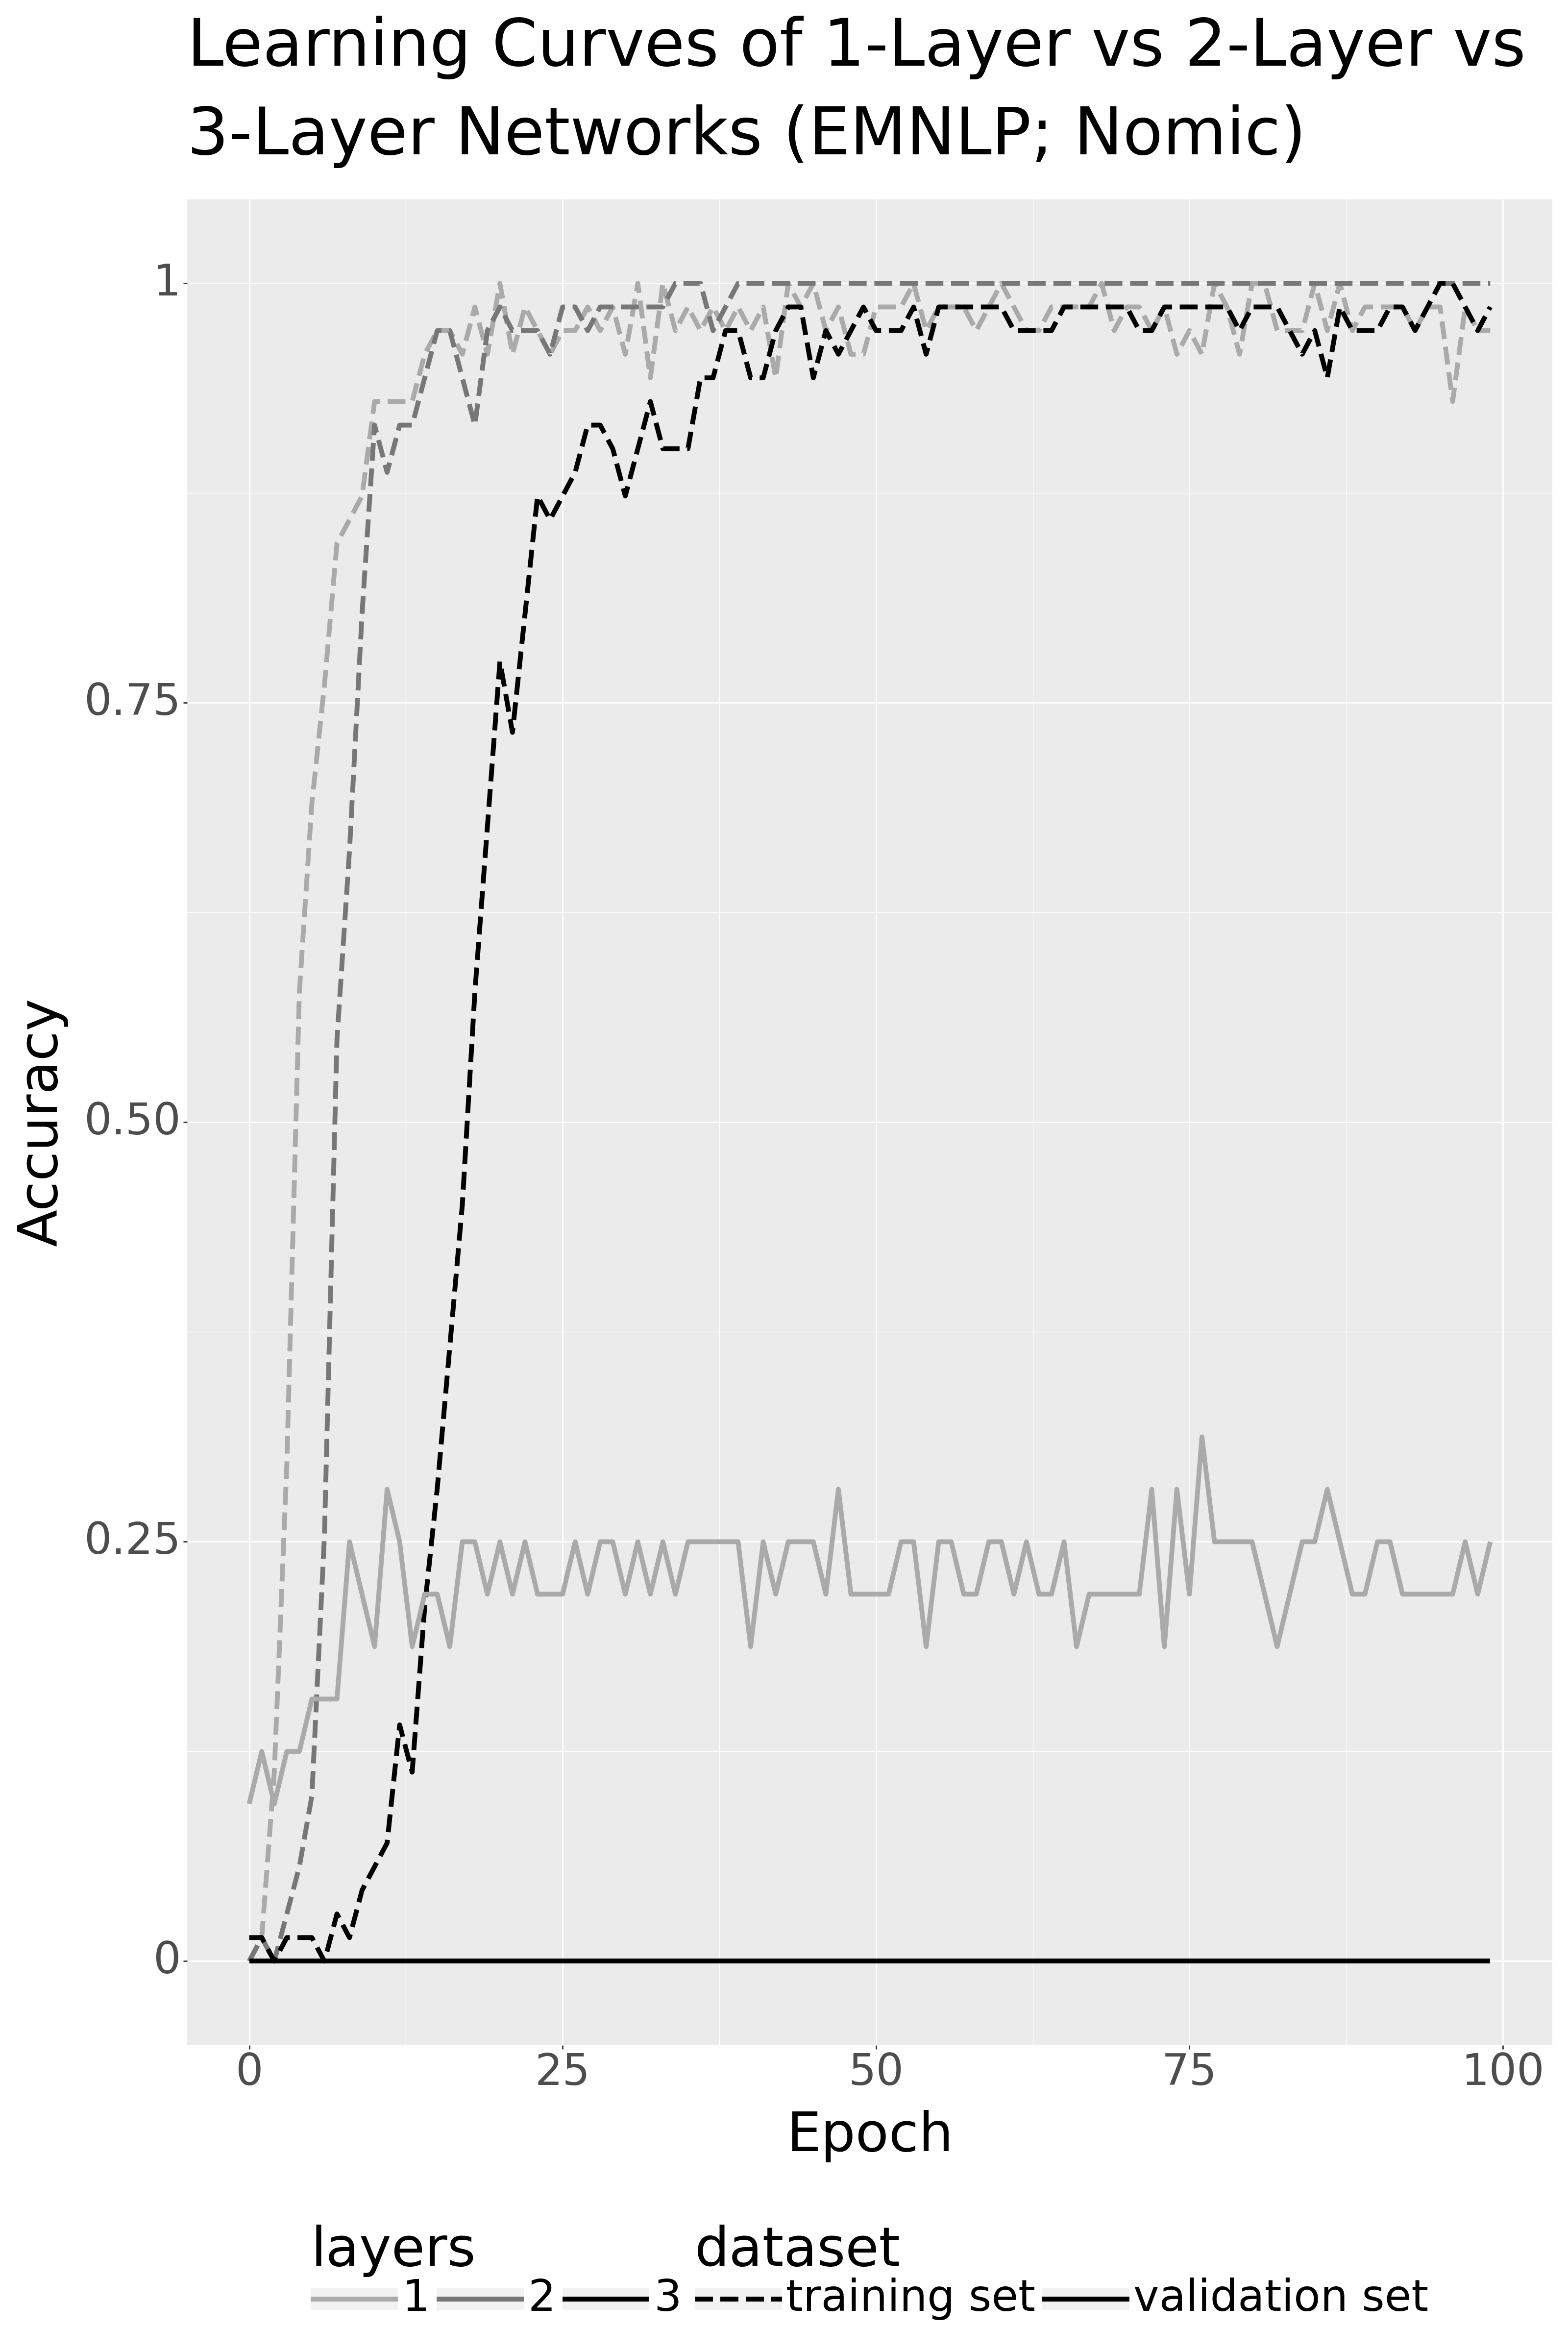

<Figure Size: (1600 x 2400)>

In [ ]:
combined_global_plot

## Final Export

In [ ]:
other_architectures_file_path = 'current-data-dump/nomic-autoencoder/other-architectures/'
other_architectures_file_path_zip = 'current-data-dump/nomic-autoencoder/other-architectures/'
shutil.make_archive(other_architectures_file_path_zip, 'zip', other_architectures_file_path)
print(f"Zip file created at: {other_architectures_file_path_zip}")
result = subprocess.run([f"osf -p sakjg upload --force {other_architectures_file_path_zip}.zip data-dump/nomic-autoencoder/other_architectures.zip"], shell=True, capture_output=True, text=True)
print(result.stderr)
print(f"File: {other_architectures_file_path_zip} uploaded at osfstorage")

## Import data

In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/nomic-autoencoder/other_architectures.zip", shell=True)
print("other_architectures.zip successfully imported")
nomic_autoencoder_file_path_zip = 'other_architectures.zip'
nomic_autoencoder_file_path = 'current-data-dump/nomic-autoencoder/other-architectures'
os.makedirs(nomic_autoencoder_file_path, exist_ok=True)
with zipfile.ZipFile(nomic_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(nomic_autoencoder_file_path)
extracted_files = os.listdir(nomic_autoencoder_file_path)
print("Files extracted:", extracted_files)

other_architectures.zip successfully imported
Files extracted: ['3-layer-architecture', 'combined_global_training_plot.png', '.zip', '2-layer-architecture']
